# 0. Package initialization

In [1]:
!pip install Cython==3.0.0a9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.1 MB ? eta -:--:--
     ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/1.1 MB 3.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 0.8/1.1 MB 12.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.5
    Uninstalling Cython-3.0.5:
      Successfully uninstalled Cython-3.0.5


In [2]:
!wget -N http://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/install_cyvlfeat.py
%run install_cyvlfeat.py

--2023-11-23 13:19:58--  http://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/install_cyvlfeat.py
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/install_cyvlfeat.py [following]
--2023-11-23 13:19:58--  https://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/install_cyvlfeat.py
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/x-python]
Saving to: ‘install_cyvlfeat.py’

install_cyvlfeat.py     [ <=>                ]   3.62K  --.-KB/s    in 0s      

2023-11-23 13:19:59 (17.6 MB/s) - ‘install_cyvlfeat.py’ saved [3710]

installing cython... done!
downloading vlfeat binaries... done!
uncompressing vlfeat binaries... done!
cloning pyvlfeat repo to cyvlfeat_git folder... done

# 0.5 Global variables

In [38]:
data_path = "data_sketches"

train_folder = "train_images"
test_folder = "test_images"
val_folder = "val_images"

feature_file = "features.csv"
label_file = "labels.csv"
index_file = "index.csv"

val_feature_file = "val_features.csv"
val_label_file = "val_labels.csv"
val_index_file = "val_index.csv"

In [33]:
def save_features(features, labels, feature_file, label_file, index_file):
  # Saving features
  # features: nimages x nfeats x 256, all features extracted
  # labels: nimages, labels of each image
  n_features_image = np.array([f.shape[0] for f in features])
  n_features_index = np.cumsum(n_features_image)
  labs = np.array(labels)
  feats = np.concatenate(features, dtype = np.int32)

  np.savetxt(feature_file, feats, delimiter=",")
  np.savetxt(label_file, labs, delimiter=',')
  np.savetxt(index_file, n_features_index, delimiter=',')

In [34]:
def create_sift_features(feature_file, label_file, index_file, data, threshold):
  # Creating sift features from dataset and saving them
  # data: dataloader of images
  # threshold: sift threshold
  features = []
  labels = []
  i = 0
  for _, (img, label) in enumerate(data):
    i+=1
    img = img[0, 1].numpy()
    if i%50==0:
      print(f"image: {i}/{len(data)} ({round(i/len(data)*100, 2)})")
      # break
    if i%1000==0:
      save_features(features, labels, feature_file, label_file, index_file)

    [frames, descrs] = cyvlfeat.sift.sift(img, peak_thresh=threshold)
    features.append(descrs)
    labels.append(label)

  save_features(features, labels, feature_file, label_file, index_file)

In [35]:
def create_histogram_dataset(feature_dictionary_file, feature_file, index_file, hist_file):
  # Creating a dataset of histogram from the dictionary of features
  feature_dictionary = np.loadtxt(feature_dictionary_file, delimiter=",")
  features = np.genfromtxt(feature_file, delimiter=",", dtype=np.int32)
  index = np.genfromtxt(index_file, delimiter=",", dtype=np.int32)

  tree = KDTree(feature_dictionary)

  nsample = index.shape[0]
  nword, _ = feature_dictionary.shape

  hist = np.zeros((nsample, nword))
  for i in range(nsample):
    if i==0:
      feats = features[:index[0]]
    else:
      feats = features[index[i-1]:index[i]]
    nfeat = feats.shape[0]
    if nfeat > 0:
      _, ind = tree.query(feats, k=1)
      for j in range(nfeat):
        hist[i, ind[j]]+=1
  np.savetxt(hist_file, hist, delimiter=',')

In [73]:
def compute_tfidf(hist_file, tfidf_file):
    # Compute the tfidf of the histogram file
    eps = 1e-5
    hist = np.loadtxt(hist_file, delimiter=",").astype(np.int64) # n x f
    print(np.sum(np.sum(hist, axis = 1)==0))
    TF = hist/(np.sum(hist, axis = 1, keepdims=True)+eps) # n (proportion where the word j appears in document i)
    IDF = np.log(hist.shape[0]/(np.sum(hist > 0, axis = 0))) # f (number of document i where j appears)
    np.savetxt(tfidf_file, TF * IDF[None, :], delimiter=',')

In [75]:
def normalize_histogram(hist_file, tfidf_file, norm_hist_file):
    # Histogram normalization with tfidf, square root and euclidian norm
    eps = 1e-5
    hist = np.loadtxt(hist_file, delimiter=",").astype(np.int64) # n x f
    tfidf = np.loadtxt(tfidf_file, delimiter=",")
    norm_hist = hist * tfidf
    norm_hist = np.sqrt(norm_hist)
    norm_hist = norm_hist/(np.linalg.norm(norm_hist, axis = 1, keepdims=True)+eps)
    
    np.savetxt(norm_hist_file, norm_hist, delimiter = ',')

# 1. First feature extraction test

In [3]:
import cyvlfeat
import numpy as np
from skimage.io import imread
from skimage.transform import resize, rotate
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from cyvlfeat.plot import plotframes
from scipy.io import loadmat
import numpy as np
import os

# change some default matplotlib parameters
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.dpi'] = 120

# ignore warnings
warnings.filterwarnings('ignore')

(1111, 1111)


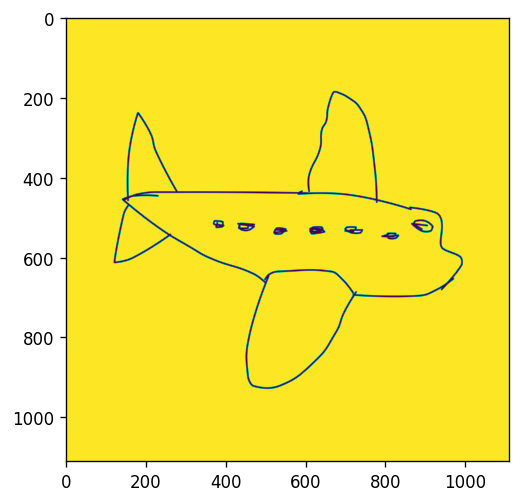

<class 'numpy.ndarray'>


In [4]:
im1 = imread('/content/drive/MyDrive/data_sketches/train_images/000_airplane/1.png')
f, (ax1) = plt.subplots(1, 1)
print(im1.shape)
ax1.imshow(im1)
plt.show()
print(type(im1))

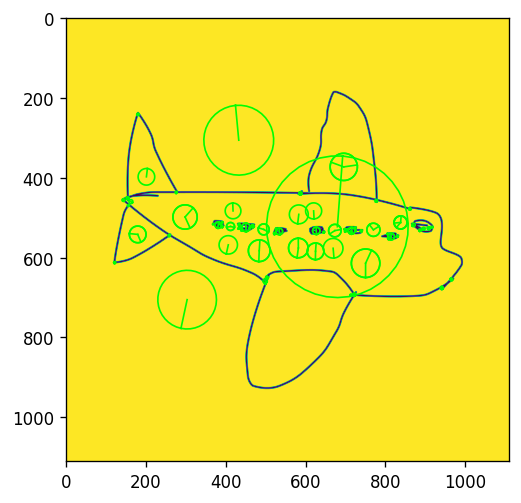

In [5]:
[frames1, descrs1] = cyvlfeat.sift.sift(im1, peak_thresh=0.01)
f, (ax1) = plt.subplots(1)
plt.sca(ax1)
plt.imshow(im1)
plotframes(frames1, linewidth=1)

# 2. Extraction de features (seulement besoin de le faire une fois)

In [7]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [8]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [9]:
train_loader = torch.utils.data.DataLoader(
      datasets.ImageFolder(os.path.join(data_path, train_folder), transform=data_transforms),
      batch_size=1,
      shuffle=True,
      num_workers=1,
  )

In [10]:
print(len(train_loader))

12000


In [18]:
create_sift_features(feature_file, label_file, index_file, train_loader, 0.01)

image: 50/12000 (0.42)
image: 100/12000 (0.83)
image: 150/12000 (1.25)
image: 200/12000 (1.67)
image: 250/12000 (2.08)
image: 300/12000 (2.5)
image: 350/12000 (2.92)
image: 400/12000 (3.33)
image: 450/12000 (3.75)
image: 500/12000 (4.17)
image: 550/12000 (4.58)
image: 600/12000 (5.0)
image: 650/12000 (5.42)
image: 700/12000 (5.83)
image: 750/12000 (6.25)
image: 800/12000 (6.67)
image: 850/12000 (7.08)
image: 900/12000 (7.5)
image: 950/12000 (7.92)
image: 1000/12000 (8.33)
image: 1050/12000 (8.75)
image: 1100/12000 (9.17)
image: 1150/12000 (9.58)
image: 1200/12000 (10.0)
image: 1250/12000 (10.42)
image: 1300/12000 (10.83)
image: 1350/12000 (11.25)
image: 1400/12000 (11.67)
image: 1450/12000 (12.08)
image: 1500/12000 (12.5)
image: 1550/12000 (12.92)
image: 1600/12000 (13.33)
image: 1650/12000 (13.75)
image: 1700/12000 (14.17)
image: 1750/12000 (14.58)
image: 1800/12000 (15.0)
image: 1850/12000 (15.42)
image: 1900/12000 (15.83)
image: 1950/12000 (16.25)
image: 2000/12000 (16.67)
image: 20

In [ ]:
val_loader = torch.utils.data.DataLoader(
      datasets.ImageFolder(os.path.join(data_path, val_folder), transform=data_transforms),
      batch_size=1,
      shuffle=True,
      num_workers=1,
  )

In [ ]:
create_sift_features(val_feature_file, val_label_file, val_index_file, val_loader, 0.01)

# 3. Creation of the feature dictionary

In [98]:
from sklearn.cluster import KMeans
import numpy as np
import pickle

In [99]:
model_knn_file = "model_knn.pkl"
filtered_features_file = "filtered_features.csv"

In [100]:
features = np.loadtxt(feature_file, delimiter=",")
print(features.shape)

(834952, 128)


In [148]:
dict_size = 5000
kmeans = KMeans(n_clusters = dict_size, n_init='auto')
kmeans.fit(features)

with open(model_knn_file, "wb") as f:
    pickle.dump(kmeans, f)

In [149]:
feature_dictionary = kmeans.cluster_centers_
np.savetxt(filtered_features_file, feature_dictionary, delimiter=',')

# 5. Dataset of histograms

In [150]:
from sklearn.neighbors import KDTree

In [151]:
hist_file = "hist.csv"
tfidf_file = "tfidf.csv"
norm_hist_file = "norm_hist.csv"
filtered_features_file = "filtered_features.csv"

In [ ]:
create_histogram_dataset(filtered_features_file, feature_file, index_file, hist_file)

In [153]:
compute_tfidf(hist_file, tfidf_file)

3496


In [154]:
normalize_histogram(hist_file, tfidf_file, norm_hist_file)

# 6. Fit SVM

In [155]:
from sklearn.svm import SVC
import pickle

In [156]:
model_svc_file = 'model_svc.pkl'
norm_hist_file = "norm_hist.csv"

In [157]:
norm_hist = np.loadtxt(norm_hist_file, delimiter = ',')
norm_hist = np.nan_to_num(norm_hist)
labels = np.loadtxt(label_file, delimiter = ',').astype(np.int32)

In [158]:
svc = SVC()
svc.fit(norm_hist, labels)

SVC()

In [159]:
with open(model_svc_file, "wb") as f:
    pickle.dump(svc, f)

In [160]:
train_pred = svc.predict(norm_hist)

In [161]:
print(np.sum(train_pred == labels)/labels.shape[0])

0.7083333333333334


# 7. Test

In [162]:
from joblib import dump, load
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from sklearn.neighbors import KDTree

In [163]:
model_svc_file = "model_svc.pkl"
filtered_features_file = "filtered_features.csv"
val_hist_file = "val_hist.csv"
val_tfidf_file = "val_tfidf.csv"
val_norm_hist_file = "val_norm_hist.csv"

In [164]:
svc = load(model_svc_file)
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [165]:
create_histogram_dataset(filtered_features_file, val_feature_file, val_index_file, val_hist_file)

In [166]:
compute_tfidf(val_hist_file, val_tfidf_file)

1


In [167]:
normalize_histogram(val_hist_file, val_tfidf_file, val_norm_hist_file)

In [168]:
val_norm_hist = np.loadtxt(val_norm_hist_file, delimiter = ',')
val_norm_hist = np.nan_to_num(val_norm_hist)
val_labels = np.loadtxt(val_label_file, delimiter = ',').astype(np.int32)
val_pred = svc.predict(val_norm_hist)

In [169]:
print(np.sum(val_pred == val_labels)/val_labels.shape[0])

0.06533333333333333


In [170]:
print(val_pred, val_labels)

[169  23 185 ... 108  59   8] [ 24 216 123 ...  38  72 181]
